In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [73]:
results = pd.read_csv('../data/results.csv')
races = pd.read_csv('../data/races.csv')
status = pd.read_csv('../data/status.csv')
circuits = pd.read_csv('../data/circuits.csv')

In [81]:
############################################
# MATTYLAD COPY EVERYTHING BELOW THX A LOT #
############################################

# if you want you can also correct my perfect english

## Question 3
### How does the altitude of a racing circuit affect the number of mechanical failures?

Formula 1 cars consists of lots of different components. Some of them are heat sensitive and require excessive cooling during the race achieved by making use of the airflow. <br>
In higher altitudes the air becomes less and less dense, thus reducing its cooling effect.

Therefore we hypothesise that there is a positive correlation beteen the altitude of a circuit and the number of mechanical failures held at that circuit.

### Merging

The finishing status of every driver per race is listed in *races*. However, *races* does not reference the circuit the result was scored on, thus we do not have direct access to the altitude. <br>
In order to have access to the altitude for each result, *results* and *races* are merged to obtain circuitId. Using circuitId to merge *circuits* we obtain the altitude for each record in *results*.

In [74]:
# merge results and races to gain 'circuitId' and 'date'
results_copy = results[['resultId', 'raceId', 'statusId']].merge(races[['raceId', 'circuitId', 'date']], on='raceId')

# merge newly obtained df and circuits to gain 'location', 'country' and 'alt'
results_copy = results_copy.merge(circuits[['circuitId', 'alt']], on='circuitId')
results_copy['alt'] = pd.to_numeric(results_copy['alt'], errors='coerce')

### Selecting

Due to the various changes in the technical regulations as well as the improvements in durability of car components, only data from year 2000 and onwards will be considered. 

In [75]:
# only take races from 2000 onwards into account
results_copy['date'] = pd.to_datetime(results_copy['date'])
results_copy = results_copy[results_copy['date'] > datetime.datetime(2000, 1, 1)]

### Labeling

Finally, we have to define 'mechanical failure'. For this analysis we decided to label a result as a 'mechanical failure' if a driver's race ended due to on of the following causes:
- engine failure
- overheating
- radiator failure
- turbo failure
- cooling system failure

*status* features a lot more failures, however most of them are not related to car components that we suspect to be influenced by high air density and therefore are not considered.

In [76]:
# indicate records with mechanical failures
statusIds_failures = [5, 25, 21, 101, 141] # engine, overheating, radiator, turbo, cooling system respectively
results_copy['mechanical_failure'] = results_copy['statusId'].isin(statusIds_failures).astype(int)

# display dataframe
print(results_copy.shape)
results_copy.head()

(9200, 7)


,resultId,raceId,statusId,circuitId,date,alt,mechanical_failure
0,1,18,1,1,2008-03-16,10.0,0
1,2,18,1,1,2008-03-16,10.0,0
2,3,18,1,1,2008-03-16,10.0,0
3,4,18,1,1,2008-03-16,10.0,0
4,5,18,1,1,2008-03-16,10.0,0


### Calculating mechanical failures per race for each altitude

After preparing the data, the next step is calculating the mechanical failures per race for each altitude. In order to achieve this, firstly the data needs to be grouped by altitude while keeping track of the number of races and failures at each altitude. After that the average number of failures per race is calculated.

In [77]:
# group by altitude
failures_at_alt = results_copy.groupby('alt').agg(
    num_races=('raceId', 'nunique'),
    num_failures=('mechanical_failure', 'sum')
).reset_index()

# calculate failures per race for each altitude
failures_at_alt['failures_per_race'] = failures_at_alt['num_failures'] / failures_at_alt['num_races']

# only take altitudes into account at which 5 or more races were hosted
failures_at_alt = failures_at_alt[failures_at_alt['num_races'] >= 5]

# display dataframe
print(failures_at_alt.shape)
failures_at_alt.head()

(25, 4)


,alt,num_races,num_failures,failures_per_race
0,-7.0,6,1,0.166667
2,2.0,8,0,0.000000
3,3.0,14,3,0.214286
4,4.0,5,2,0.400000
5,5.0,16,4,0.250000


### Results
In the following section the correlation between the altitude and failures per race is calulcated and a scatterplot including regression line is displayed.

In [78]:
# calculate correlation between altitiude and failures per race
corr_alt_failures = failures_at_alt['alt'].corr(failures_at_alt['failures_per_race'])

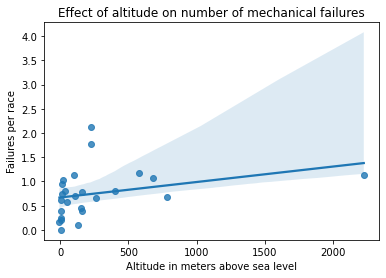

Correlation between altitude and failures per race: 0.2998


In [79]:
# display results
sns.regplot(data=failures_at_alt, x='alt', y='failures_per_race')
plt.xlabel('Altitude in meters above sea level')
plt.ylabel('Failures per race')
plt.title('Effect of altitude on number of mechanical failures')
plt.show()
print('Correlation between altitude and failures per race:', round(corr_alt_failures, 4))

As one can see, the correlation is significantly lower than expected. 

We came to the conclusion that this likely refers to the fact that the data is heavily skewd towards lower altitudes, as a lot of race tracks are build close to the coast. Additionally, there are various different reasons for cooling sensitive parts to fail, such as high temperature, humidity or sand.